In [582]:
import pandas as pd
import requests
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Load in the data

In [208]:
#Obtain the JSON file of mock-data
r = requests.get('https://corona-tracker-mock.herokuapp.com/users')
mock_data = r.json()
mock_df = pd.DataFrame.from_dict(mock_data)

In [209]:
#Parse through the observation JSON bundles to extract them in a more understandable form
obv_dfs = []
for i,o in enumerate(mock_df.observation):
    i = i + 1
    obv_dfs.append(pd.DataFrame.from_dict(o).T)

In [210]:
mock_df.observation = obv_dfs

In [211]:
mock_df

,id,title,observation,coronavirus,demographics,comorbidites
0,11,user1,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
1,12,user2,p...,{'confirmed': True},{},"{'cadiosvascular': {}, 'endocrine': {}}"
2,13,user3,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
3,14,user4,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
4,15,user5,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
5,16,user6,p...,{'confirmed': True},{},"{'cadiosvascular': {}, 'endocrine': {}}"
6,17,user7,p...,{'confirmed': True},{},"{'cadiosvascular': {}, 'endocrine': {}}"
7,18,user8,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
8,19,user9,p...,{'confirmed': False},{},"{'cadiosvascular': {}, 'endocrine': {}}"
9,20,user10,p...,{'confirmed': True},{},"{'cadiosvascular': {}, 'endocrine': {}}"


### Clean up the data

In [225]:
#Extract values and prepare them for a dataframe that is exclusively entries
cols = list(mock_df.observation.loc[0].physical[0].keys())
#cols.append('status')

entries = pd.DataFrame(columns=cols)

for user in mock_df.iterrows():
    status = user[1].coronavirus
    for o in user[1].observation.physical:
        o['status'] = status['confirmed']
        df2 = pd.DataFrame(o,index=[0])
        entries = entries.append(df2, ignore_index=True)

In [226]:
entries

,id,fever,chills,breathShortnes,fatigue,dryCough,soreThroat,bluLipsFace,gastrointestinnal,headache,temperature,observation_id,created_at,updated_at,status
0,1,None,Severe,Severe,None,Moderate,Moderate,Moderate,Moderate,Minimal,NaN,1,2020-04-09T18:59:04.219Z,2020-04-09T18:59:04.219Z,False
1,2,None,Severe,Minimal,Moderate,Minimal,Moderate,Moderate,None,None,NaN,2,2020-04-09T18:59:04.250Z,2020-04-09T18:59:04.250Z,False
2,3,Minimal,Moderate,Severe,None,None,Minimal,Severe,Moderate,Moderate,99,3,2020-04-09T18:59:04.263Z,2020-04-09T18:59:04.263Z,False
3,4,Severe,Minimal,Moderate,Moderate,Severe,Severe,Severe,None,Moderate,106.657,4,2020-04-09T18:59:04.275Z,2020-04-09T18:59:04.275Z,False
4,5,Moderate,Minimal,Moderate,Severe,Minimal,Minimal,None,Moderate,Severe,100.003,5,2020-04-09T18:59:04.287Z,2020-04-09T18:59:04.287Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Moderate,None,Moderate,Severe,Minimal,Severe,Minimal,Severe,Severe,99.6493,496,2020-04-09T18:59:10.802Z,2020-04-09T18:59:10.802Z,True
496,497,Minimal,Severe,Severe,None,Severe,Minimal,None,Moderate,Severe,99,497,2020-04-09T18:59:10.814Z,2020-04-09T18:59:10.814Z,True
497,498,None,Minimal,Severe,Moderate,Minimal,Severe,Minimal,Severe,Severe,None,498,2020-04-09T18:59:10.825Z,2020-04-09T18:59:10.825Z,True
498,499,Moderate,Minimal,None,Minimal,Minimal,Minimal,Severe,Moderate,Moderate,100.153,499,2020-04-09T18:59:10.839Z,2020-04-09T18:59:10.839Z,True


In [229]:
#Fix typos
entries = entries.rename(columns={'breathShortnes':'breathShortness',
                          'bluLipsFace':'blueLipsFace','gastrointestinnal':'gastrointestinal'})
entries

,id,fever,chills,breathShortness,fatigue,dryCough,soreThroat,blueLipsFace,gastrointestinal,headache,temperature,observation_id,created_at,updated_at,status
0,1,None,Severe,Severe,None,Moderate,Moderate,Moderate,Moderate,Minimal,NaN,1,2020-04-09T18:59:04.219Z,2020-04-09T18:59:04.219Z,False
1,2,None,Severe,Minimal,Moderate,Minimal,Moderate,Moderate,None,None,NaN,2,2020-04-09T18:59:04.250Z,2020-04-09T18:59:04.250Z,False
2,3,Minimal,Moderate,Severe,None,None,Minimal,Severe,Moderate,Moderate,99,3,2020-04-09T18:59:04.263Z,2020-04-09T18:59:04.263Z,False
3,4,Severe,Minimal,Moderate,Moderate,Severe,Severe,Severe,None,Moderate,106.657,4,2020-04-09T18:59:04.275Z,2020-04-09T18:59:04.275Z,False
4,5,Moderate,Minimal,Moderate,Severe,Minimal,Minimal,None,Moderate,Severe,100.003,5,2020-04-09T18:59:04.287Z,2020-04-09T18:59:04.287Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Moderate,None,Moderate,Severe,Minimal,Severe,Minimal,Severe,Severe,99.6493,496,2020-04-09T18:59:10.802Z,2020-04-09T18:59:10.802Z,True
496,497,Minimal,Severe,Severe,None,Severe,Minimal,None,Moderate,Severe,99,497,2020-04-09T18:59:10.814Z,2020-04-09T18:59:10.814Z,True
497,498,None,Minimal,Severe,Moderate,Minimal,Severe,Minimal,Severe,Severe,None,498,2020-04-09T18:59:10.825Z,2020-04-09T18:59:10.825Z,True
498,499,Moderate,Minimal,None,Minimal,Minimal,Minimal,Severe,Moderate,Moderate,100.153,499,2020-04-09T18:59:10.839Z,2020-04-09T18:59:10.839Z,True


In [485]:
#Extract only features of interest and target (COVID-19 status)
data = entries[['fever','chills','breathShortness','fatigue','dryCough',
                  'soreThroat','blueLipsFace','gastrointestinal','headache','temperature','status']]

### Convert data into pytorch understandable format

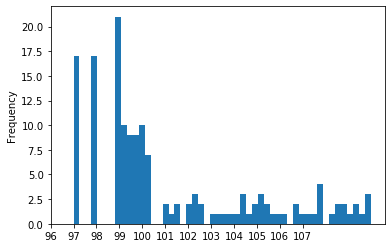

In [486]:
df = data[(data != 0).all(1)]
df['temperature'].plot.hist(bins=50,xticks=[96,97,98,99,100,101,102,103,104,105,106,107])

In [487]:
#Convert the strings into ints for analysis
data.replace(to_replace=data[data == "None"], value=int(0), inplace=True)
data.replace(to_replace=data[data == "Minimal"], value=int(1), inplace=True)
data.replace(to_replace=data[data == "Moderate"], value=int(2), inplace=True)
data.replace(to_replace=data[data == "Severe"], value=int(3), inplace=True)


#Bucketize the temperatures
data.replace(to_replace=data[data > 103], value=int(3), inplace=True)
data.replace(to_replace=data[data > 100.4], value=int(2), inplace=True)
data.replace(to_replace=data[data >= 97.0], value=int(1), inplace=True)
#data.replace(to_replace=data[data <= 97.0], value=int(0), inplace=True)

#Isolate the targets as well
data["status"] = data["status"].astype(int)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [488]:
data

,fever,chills,breathShortness,fatigue,dryCough,soreThroat,blueLipsFace,gastrointestinal,headache,temperature,status
0,0,3,3,0,2,2,2,2,1,0.0,0
1,0,3,1,2,1,2,2,0,0,0.0,0
2,1,2,3,0,0,1,3,2,2,1.0,0
3,3,1,2,2,3,3,3,0,2,3.0,0
4,2,1,2,3,1,1,0,2,3,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
495,2,0,2,3,1,3,1,3,3,1.0,1
496,1,3,3,0,3,1,0,2,3,1.0,1
497,0,1,3,2,1,3,1,3,3,0.0,1
498,2,1,0,1,1,1,3,2,2,1.0,1


### Extract the features and targets

In [492]:
X = data.iloc[:, 0:-1]
Y = data.iloc[:, -1]

In [493]:
#Split the training and test data
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Establish model parameters

In [694]:
epochs = 100
batch_size = 50

### Load the data

In [673]:
#Develop a custom data loader

#Train data
class dataSet(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [674]:
train_dataset = dataSet(torch.from_numpy(X_train.values).float(), torch.from_numpy(Y_train.values).float())

In [675]:
test_dataset = dataSet(torch.from_numpy(x_test.values).float(), torch.from_numpy(y_test.values).float())

In [676]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Xtrain = torch.from_numpy(X_train.values).float()
Xtest = torch.from_numpy(x_test.values).float()

#Ytrain = torch.from_numpy(Y_train.values).reshape(1,-1)[0].long()
Ytrain = torch.from_numpy(Y_train.values).float()
#Ytest = torch.from_numpy(y_test.values).reshape(1,-1)[0].long()

### Defining our neural network

In [716]:
class binaryClassification(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, act_fn="sigmoid", apply_dropout=False):
        super(binaryClassification, self).__init__()
        
        # Linear Functions
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        #Number of hidden layers
        self.hidden_dim = hidden_dim
        
        # Activation function
        self.act_fn = act_fn
        
        #Consider use of dropout
        self.dropout = None
        if apply_dropout:
            self.dropout = nn.Dropout(0.5)
        
    
    # Here's where we connect all the layers together
    def forward(self, x):
        
        #Set activation function from user input
        act_fn = None
        if self.act_fn == 'sigmoid':
            act_fn = F.torch.sigmoid
        elif self.act_fn == 'tanh':
            act_fn = F.torch.tanh
        elif self.act_fn == 'relu':
            act_fn = F.torch.relu
            
        #Pass through the layers
        x = act_fn(self.fc1(x))
        
        #Apply dropout only before final layer
        if self.dropout != None:
            x = self.dropout(x)
        
        #Output layer
        x = self.fc2(x)
        
        return x

#To calculate accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [721]:
def train_model(model, n_epochs):
    criterion = nn.BCEWithLogitsLoss()
    learning_rate = 0.1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    iteration = 0
    for epochs in range(n_epochs):

        for i, (x, y) in enumerate(train_loader):

            # Make sure they accumulate gradients!
            x = x.requires_grad_()

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get the output/logits
            output = model(x)

            # Calculate Loss
            loss = criterion(output, y.unsqueeze(1))

            # Get gradients w.r.t. the parameters
            loss.backward()

            # Update the parameters
            optimizer.step()

            iteration += 1

            # Every 50 iterations, check up on how the model is doing, 
            # by printing the loss and the training accuracy on the held out data. 
            # Accuracy = (number of test statuses correctly identified) / (total number of statuses)
            #### your code here ####
            if iteration % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for x, y in test_loader:
                    # Load images with gradient accumulation capabilities
                    x = x.requires_grad_()

                    # Forward pass only to get logits/output
                    outputs = model.forward(x)

                    # Get predictions from the maximum value
                    _, predictions = torch.max(outputs.data, 1)

                    # Get the total number of labels
                    total += y.size(0)

                    # Calculate the total correct predictions
                    overlap = predictions.eq(y)
                    correct += (overlap == True).sum().item()

                accuracy = 100 * (correct/total)

                # Print Loss
                print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iteration, loss.item(), accuracy))


In [722]:
input_dim = Xtrain.shape[1]
hidden_dim = 100
output_dim = 1
model1 = binaryClassification(input_dim, hidden_dim, output_dim, act_fn="sigmoid", apply_dropout=True)
model1

binaryClassification(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [723]:
train_model(model1, epochs)

Iteration: 50. Loss: 0.6870985627174377. Accuracy: 59.0
Iteration: 100. Loss: 0.6715657711029053. Accuracy: 59.0
Iteration: 150. Loss: 0.6166757345199585. Accuracy: 59.0
Iteration: 200. Loss: 0.6648158431053162. Accuracy: 59.0
Iteration: 250. Loss: 0.6687824130058289. Accuracy: 59.0
Iteration: 300. Loss: 0.5824536085128784. Accuracy: 59.0
Iteration: 350. Loss: 0.6764872074127197. Accuracy: 59.0
Iteration: 400. Loss: 0.6307142376899719. Accuracy: 59.0
Iteration: 450. Loss: 0.6313285231590271. Accuracy: 59.0
Iteration: 500. Loss: 0.5571582317352295. Accuracy: 59.0
Iteration: 550. Loss: 0.5828171968460083. Accuracy: 59.0
Iteration: 600. Loss: 0.6478984355926514. Accuracy: 59.0
Iteration: 650. Loss: 0.5844796299934387. Accuracy: 59.0
Iteration: 700. Loss: 0.6814886331558228. Accuracy: 59.0
Iteration: 750. Loss: 0.611373245716095. Accuracy: 59.0
Iteration: 800. Loss: 0.5634738802909851. Accuracy: 59.0


In [720]:
model2 = binaryClassification(input_dim, 500, output_dim, act_fn="sigmoid", apply_dropout=True)
train_model(model2, epochs)

Iteration: 50. Loss: 0.7026722431182861. Accuracy: 59.0
Iteration: 100. Loss: 0.6750921607017517. Accuracy: 59.0
Iteration: 150. Loss: 0.6507409811019897. Accuracy: 59.0
Iteration: 200. Loss: 0.7150540351867676. Accuracy: 59.0
Iteration: 250. Loss: 0.6801145672798157. Accuracy: 59.0
Iteration: 300. Loss: 0.8314441442489624. Accuracy: 59.0
Iteration: 350. Loss: 0.6331886053085327. Accuracy: 59.0
Iteration: 400. Loss: 0.6044279336929321. Accuracy: 59.0
Iteration: 450. Loss: 0.5754648447036743. Accuracy: 59.0
Iteration: 500. Loss: 0.593205988407135. Accuracy: 59.0
Iteration: 550. Loss: 0.5602843761444092. Accuracy: 59.0
Iteration: 600. Loss: 0.547904908657074. Accuracy: 59.0
Iteration: 650. Loss: 0.5252075791358948. Accuracy: 59.0
Iteration: 700. Loss: 0.5138750672340393. Accuracy: 59.0
Iteration: 750. Loss: 0.638206958770752. Accuracy: 59.0
Iteration: 800. Loss: 0.5590859055519104. Accuracy: 59.0


In [586]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
print (len(y_test), len(y_pred_list))
print(classification_report(y_test, y_pred_list))

In [406]:
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetwork, self).__init__()
        
        # Linear Function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Non-linearity (Use a sigmoid for now)
        self.sig = nn.Sigmoid()
        
        # Another linear function (the readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    # Here's where we connect all the layers together
    def forward(self, x):
        # Linear function
        l = self.fc1(x.T)
        
        # Non-linearity 
        s = self.sig(l)
        
        # The final linear function
        out = self.fc2(s)
        
        # aaaaannnddd spit out the output
        return out

In [414]:
input_dim = Xtrain.shape[0]*Xtrain.shape[1]
hidden_dim = 10
output_dim = 2
model = FeedforwardNeuralNetwork(input_dim, hidden_dim, output_dim)

10


In [413]:
accuracy = 0.0
epoch_data = []
num_epochs = 1000

for epoch in range(num_epochs):

    #Zero the gradients
    optimizer.zero_grad()

    #Set to training mode because of dropout
    model.train()

    #Outputs
    outputs = model(Xtrain)

    # Calculate Loss: log_softmax --> negative log likelihood
    loss = criterion(outputs, Ytrain)

    # Getting gradients w.r.t. parameters
    loss.backward()

    #Update our parameters
    optimizer.step()

    #Return to evaluation mode
    model.eval()

    #Work with the test data
    outputs_test = model(Xtest)
    loss_test = criterion(outputs_test, Ytest)

    _, prediction = outputs_test.data.max(1)

    accuracy = prediction.eq(Ytest.data).sum.item()/y_test.values.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])

    if epoch % 100 == 0:
        print ('Epoch: %d (%d%%) train loss - %.2f test loss - %.2f test accuracy - %.4f'\
              % (epoch, epoch/150 *10, loss.data.item(), loss_test.data.item(), accuracy))

return {'model': model,
       'epoch_data':epoch_data,
       'num_epochs':num_epochs,
       'optimizer':optimizer,
       'loss_fn':criterion,
       'accuracy':accuracy,
       '_, pred':outputs_test.data.max(1),
       'actual_test_label':Ytest,}

ValueError: Expected input batch_size (10) to match target batch_size (400).